## TFRecord

The usage has been demonstrated with **Cats and Dogs** dataset from **Kaggle**

### 1) Creating TFRecord file

**A) Loading the images**

**glob** is used for returning a list of paths **matching a pathname pattern**.

In [1]:
import glob

In [2]:
cat_dog_train_path = '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/*.jpg'

In [3]:
addrs = glob.glob(cat_dog_train_path)

In [4]:
addrs[:5]

['/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/dog.228.jpg',
 '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/cat.11479.jpg',
 '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/cat.277.jpg',
 '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/dog.12110.jpg',
 '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/cat.1112.jpg']

Create labes from path names

In [5]:
"dog" in addrs[0]

True

In [6]:
labels = [0 if 'cat' in f else 1 for f in addrs]

In [7]:
labels[:5]

[1, 0, 0, 1, 0]

**Shuffle data**

In [8]:
c = list(zip(addrs,labels))

In [9]:
from random import shuffle

shuffle(c)

In [10]:
x,l = zip(*c)

In [50]:
x[:5],l[:5]

(('/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/cat.5763.jpg',
  '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/cat.1584.jpg',
  '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/dog.5972.jpg',
  '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/dog.8838.jpg',
  '/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/dog.6671.jpg'),
 (0, 0, 1, 1, 1))

**Function for loading image**

In [11]:
import cv2
import numpy as np

def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [12]:
img = load_image(x[0])
img.shape

(224, 224, 3)

**Visualize image**

In [13]:
%matplotlib inline
from matplotlib.pyplot import imshow

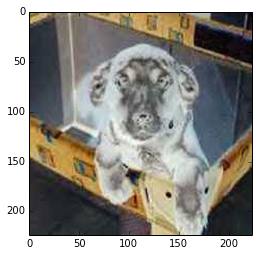

In [14]:
imshow(img)

#### B) Preparing TFRecord file

In [15]:
import tensorflow as tf

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


**Images in numpy array have to be converted to bytes**

In [16]:
type(tf.compat.as_bytes(img.tostring()))

bytes

In [17]:
type(img.tobytes())

bytes

**STEPS FOR SERIALIZING TO TFRecord FILE**

**ILLUSTRATION**

i) Create a **protobuf list** for the features

In [18]:
il = tf.train.Int64List(value=[1,2,3])
il

value: 1
value: 2
value: 3

In [83]:
type(il)

tensorflow.core.example.feature_pb2.Int64List

ii) Get **tf.train.Feature** from the protobuf list

In [90]:
fi = tf.train.Feature(int64_list=il)
fi

int64_list {
  value: 1
  value: 2
  value: 3
}

In [144]:
type(fi)

tensorflow.core.example.feature_pb2.Feature

iii) Get **tf.train.Features** from tf.train.Feature

In [107]:
fe = tf.train.Features(feature={"fi":fi})
fe

feature {
  key: "fi"
  value {
    int64_list {
      value: 1
      value: 2
      value: 3
    }
  }
}

In [145]:
type(fe)

tensorflow.core.example.feature_pb2.Features

iv) Create **tf.Train.Example** from Features

In [113]:
eg = tf.train.Example(features=fe)
eg

features {
  feature {
    key: "fi"
    value {
      int64_list {
        value: 1
        value: 2
        value: 3
      }
    }
  }
}

v) **Serialize** example to string

In [128]:
egs = eg.SerializeToString()
egs

b'\n\x0f\n\r\n\x02fi\x12\x07\x1a\x05\n\x03\x01\x02\x03'

#### Consolidated code

In [37]:
train_filename = 'train.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(x)):
    
    if not i % 1000:
        print('Train data: {}/{}'.format(i, len(x)))
    
    #img = load_image(x[i])
    
    feature = {
        "train/label":tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(l[i])])),
         "train/image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img.tostring())]))
    }
    
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    writer.write(example.SerializeToString())
    
writer.close()
print("Wrote to ", train_filename)

Train data: 0/25000
Train data: 1000/25000
Train data: 2000/25000
Train data: 3000/25000
Train data: 4000/25000
Train data: 5000/25000
Train data: 6000/25000
Train data: 7000/25000
Train data: 8000/25000
Train data: 9000/25000
Train data: 10000/25000
Train data: 11000/25000
Train data: 12000/25000
Train data: 13000/25000
Train data: 14000/25000
Train data: 15000/25000
Train data: 16000/25000
Train data: 17000/25000
Train data: 18000/25000
Train data: 19000/25000
Train data: 20000/25000
Train data: 21000/25000
Train data: 22000/25000
Train data: 23000/25000
Train data: 24000/25000
Wrote to  train.tfrecords


### 2) Reading TFRecord file

**Create a queue and reader**

In [146]:
data_path = 'train.tfrecords'

filename_queue = tf.train.string_input_producer([data_path])
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

**Define the features and parse it**

In [147]:
feature = {'train/image': tf.FixedLenFeature([], tf.string),
           'train/label': tf.FixedLenFeature([], tf.int64)}

features = tf.parse_single_example(serialized_example, features=feature)

In [148]:
features

{'train/image': <tf.Tensor 'ParseSingleExample_6/ParseSingleExample:0' shape=() dtype=string>,
 'train/label': <tf.Tensor 'ParseSingleExample_6/ParseSingleExample:1' shape=() dtype=int64>}

**Preprocess image**

In [155]:
# Convert the image data from string back to the numbers
image = tf.decode_raw(features['train/image'], tf.float32)
# Reshape image data into the original shape
image = tf.reshape(image, [224, 224, 3])
image

<tf.Tensor 'Reshape_2:0' shape=(224, 224, 3) dtype=float32>

**Make batches**

In [157]:
label = features['train/label']

# Creates batches by randomly shuffling tensors
images, labels = tf.train.shuffle_batch([image, label], batch_size=10,
                                        capacity=30, num_threads=1, min_after_dequeue=10)

**Run the session**

In [172]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    img, lbl = sess.run([images,labels])

    coord.request_stop()
    coord.join(threads)

In [173]:
img.shape, lbl.shape

((10, 224, 224, 3), (10,))

**Visualize images**

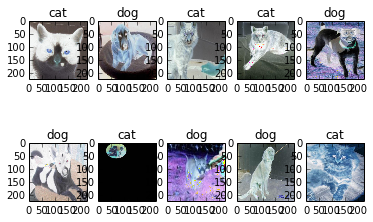

In [174]:
import matplotlib.pyplot as plt

for j in range(len(img)):
    plt.subplot(2, 5, j+1)
    plt.imshow(img[j, ...])
    plt.title('cat' if lbl[j]==0 else 'dog')
plt.show()

In [175]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    img, lbl = sess.run([images,labels])

    coord.request_stop()
    coord.join(threads)

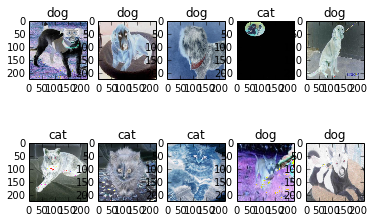

In [176]:
for j in range(len(img)):
    plt.subplot(2, 5, j+1)
    plt.imshow(img[j, ...])
    plt.title('cat' if lbl[j]==0 else 'dog')
plt.show()

### 3) Size of TFRecord file

We decompressed the jpeg image and wrote the raw array on to the TFRecord file. The Size exploded to 15GB.
Hence, we will store the raw jpeg string and do the decompress operation while reading

The decompression operation is done while fetching the mini batch by the queue runners. This is extra work at run time. But this does not cause much of a lag.

**Size comparision of Compressed and decompressed image**

In [38]:
x[0]

'/home/sankaran/exercise/ML/TF-Exercise/Low_Level_APIs/Cats&Dogs/train/dog.3125.jpg'

Compressed

In [198]:
with open(x[0],"rb") as f:
    c = f.read()
len(c)

8247

Uncompressed

In [200]:
ix = load_image(x[0])
len(ix.tobytes())

602112

In [203]:
len(tf.compat.as_bytes(ix.tostring()))

602112

**Creating TFRecord file with raw jpg string**

File size is now same as the dataset size (~570MB) 

In [372]:
train_filename = 'train_raw.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(x)):
    
    if not i % 1000:
        print('Train data: {}/{}'.format(i, len(x)))
    
    #img = load_image(x[i])
    with open(x[i],"rb") as f:
        img = f.read()
    
    feature = {
        "train/label":tf.train.Feature(int64_list=tf.train.Int64List(value=[l[i]])),
         "train/image":tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))
    }
    
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    writer.write(example.SerializeToString())
    
writer.close()
print("Wrote to ", train_filename)

Train data: 0/25000
Train data: 1000/25000
Train data: 2000/25000
Train data: 3000/25000
Train data: 4000/25000
Train data: 5000/25000
Train data: 6000/25000
Train data: 7000/25000
Train data: 8000/25000
Train data: 9000/25000
Train data: 10000/25000
Train data: 11000/25000
Train data: 12000/25000
Train data: 13000/25000
Train data: 14000/25000
Train data: 15000/25000
Train data: 16000/25000
Train data: 17000/25000
Train data: 18000/25000
Train data: 19000/25000
Train data: 20000/25000
Train data: 21000/25000
Train data: 22000/25000
Train data: 23000/25000
Train data: 24000/25000
Wrote to  train_raw.tfrecords


### 4) Decoding JPEG Image

In [23]:
with open(x[0],"rb") as f:
    c = f.read()
len(c)

7589

In [24]:
type(c)

bytes

**Decoding can be done with openCV. But this should be done under session**

In [40]:
cx = cv2.imdecode(np.fromstring(c, dtype=np.uint8),1)
cx = cv2.resize(cx, (224, 224), interpolation=cv2.INTER_CUBIC)
cx = cv2.cvtColor(cx, cv2.COLOR_BGR2RGB)
cx = cx.astype(np.float32)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


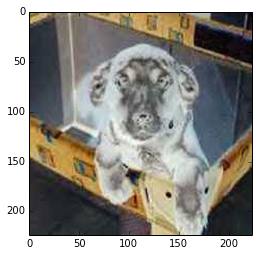

In [41]:
imshow(cx)

In [27]:
cx.shape

(224, 224, 3)

**Decoding with tensorflow**

In [29]:
ct = tf.image.decode_jpeg(c)

In [30]:
cn = tf.Session().run(ct)

In [31]:
cn.shape

(198, 215, 3)

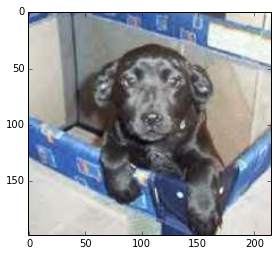

In [32]:
imshow(cn)

**NOTE:** Other interpolation methods causes noise when converted to float!

In [42]:
ctr = tf.image.resize_images(ct,(224,224),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
ctrn = tf.Session().run(ctr)

In [44]:
ctrn.shape

(224, 224, 3)

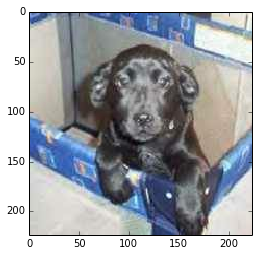

In [45]:
imshow(ctrn)

**NOTE :** Color change when cast to float

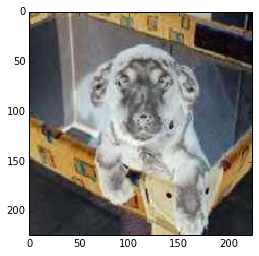

In [36]:
imshow(ctrn.astype(float))

**Consolidated Reading code**

In [20]:
data_path = 'train_raw.tfrecords'

filename_queue = tf.train.string_input_producer([data_path])
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

feature = {'train/image': tf.FixedLenFeature([], tf.string),
           'train/label': tf.FixedLenFeature([], tf.int64)}

features = tf.parse_single_example(serialized_example, features=feature)

image_j = tf.image.decode_jpeg(features['train/image'])
image_j = tf.image.resize_images(image_j,(224,224),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image_j = tf.reshape(image_j, [224, 224, 3]) ##Causes error without shapes being defined
#image_j = tf.cast(image_j,tf.float32)

label = features['train/label']

# Creates batches by randomly shuffling tensors
images, labels = tf.train.shuffle_batch([image_j, label], batch_size=10,
                                        capacity=30, num_threads=1, min_after_dequeue=10)

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    img, lbl = sess.run([images,labels])
    #img, lbl = sess.run([image_j,label]) #While debugging, keep running the variables in reverse order

    coord.request_stop()
    coord.join(threads)

**Visualizing**

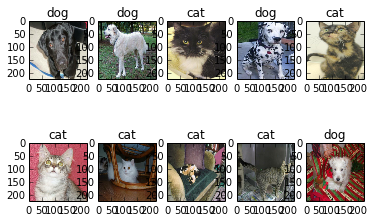

In [21]:
import matplotlib.pyplot as plt

for j in range(len(img)):
    plt.subplot(2, 5, j+1)
    plt.imshow(img[j, ...])
    plt.title('cat' if lbl[j]==0 else 'dog')
plt.show()

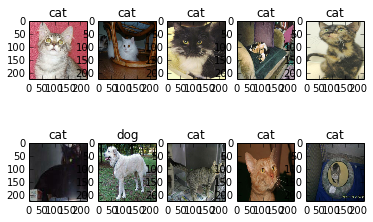

In [22]:
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    img, lbl = sess.run([images,labels])
    #img, lbl = sess.run([image_j,label])

    coord.request_stop()
    coord.join(threads)
    
for j in range(len(img)):
    plt.subplot(2, 5, j+1)
    plt.imshow(img[j, ...])
    plt.title('cat' if lbl[j]==0 else 'dog')
plt.show()